# Thermodynamic model implementation

Once working this will need to mostly go in a module. Until then it's here.

This implements the Fe-FeO thermodynamic model of Komabayashi 2014
(Thermodynamics of melting relations in the system Fe-FeO at high pressure:
Implications for oxygen in the Earth’s core, JGR 119, 4164-4177,
http://dx.doi.org/10.1002/2014JB010980). 

There are, I think, six steps:

1) Evaluate G(1bar, T) for HPC Fe, FeO and both liquids from equation 2 (polynomial evaluation) 

2) Evaluate V at a set of pressures between 1 bar and P at 298 K from equation 3 (root finding)

3) Evaluate alpha at each V from equation 5 (evaluate function)

4) Assume alpha does not vary with T and thermally expand each V from 298K (step 2) to T (evaluate function)

5) Integrate V (from step 4) from 1 bar to P and add to G(1bar, T) (equation 2, numerical integration).

This gives our end member free energies / chemical potentials. Then.

6) Calculate chemical potentials in liquid at composition X from equation 7. It looks like we'll want the ideal solid solution model as the non-ideal one (which comes from Frost) is clearly broken when extrapolated to high pressure. Add the chemical potentials to get the free energy of the liquid.

In [28]:
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

## P-V-T EOS

These cells implement steps 2 - 4

In [25]:
def vinet_eos_volume(p, v0, k0, kp):
    """
    Return the volume at some pressure
    
    Given 1 bar reference volume (v0), bulk modulus (k0),
    and its pressure derivative (kp) return the volume
    at pressure p. These should normally all be values
    at 298 K (thermal expansion is added later). Units 
    of p and k0 are GPa, v0 and the returned volume
    are cm^3/mol, and kp is dimensionless. The solution
    is via a root finding method.
    """
    
    p = spo.brentq(_pressure_error, 2.0, 20.0,
                        args=(v0, k0, kp, p))

    return p
    

# Avoid hand coding loops. Cannot numba vectorize 
# function due to brentq...
vinet_eos_volumes = np.vectorize(vinet_eos_volume)


def _pressure_error(v, v0, k0, kp, p_target):
    return vinet_eos_pressure(v, v0, k0, kp) - p_target
    

def vinet_eos_pressure(v, v0, k0, kp):
    """
    Return the pressure at some volume
    
    Given 1 bar reference volume (v0), bulk modulus (k0),
    and its pressure derivative (kp) return the pressure
    at volume v. These should normally all be values
    at 298 K (thermal expansion is added later). Units 
    of the returned pressure and k0 are GPa, w and v0 
    are cm^3/mol, and kp is dimensionless. 
    """
    x = (v/v0)**(1.0/3.0)
    p = 3.0 * k0 * x**-2 * (1.0 - x) * np.exp(
           1.5 * (kp - 1.0) * (1.0 - x))
    return p

In [27]:
# Volumes of liquid Fe at 298 K
ps = np.linspace(0.0, 360.0)
v_298 = vinet_eos_volumes(ps, 6.88, 148.0, 5.8)

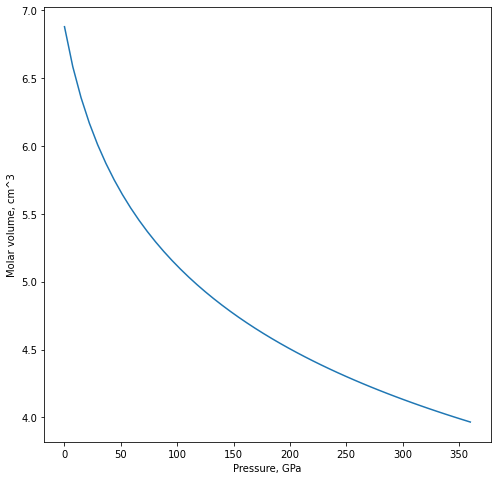

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, v_298)
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Molar volume, cm^3')
# ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
plt.show()

In [40]:
def thermal_expansion(v, v0, a0, ag0, k):
    """
    Parameterisation of thermal expansion with pressure
    
    Uses Anderson-Gruneisen parameter. v is the volume
    of interest (i.e. at some pressure), v0 is the reference
    volume, a0 is the reference thermal expansivity, ag0
    is the 1 bar Anderson-Gruneisen parameter, k is a 
    dimensionless parameter.
    EQ5 of K14
    """
    a = a0 * np.exp(-1.0 * (ag0/k) * (1 - (v / v0)**k))
    return a


def expand_volume(v, t, v0, a0, ag0, k):
    """
    Calculate thermal expansion and apply to 'cold' volume
    """
    a = thermal_expansion(v, v0, a0, ag0, k)
    dt = t - 298.0 # How much hotter
    v_hot = v + (a * v * dt)
    return v_hot

In [41]:
v_5000 = expand_volume(v_298, 5000.0, 6.88, 9.0e-5, 5.1, 1.4)

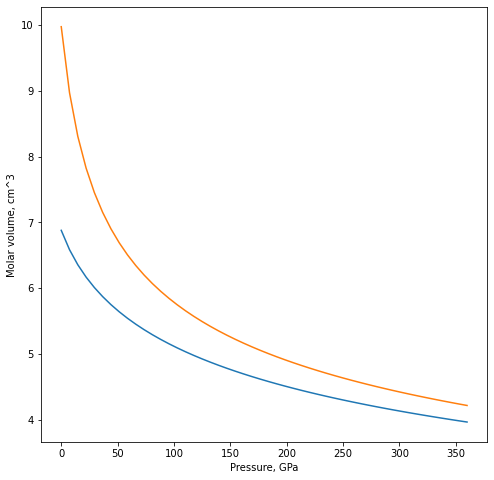

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, v_298)
ax.plot(ps, v_5000)
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Molar volume, cm^3')
# ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
plt.show()

# End member free energy

Steps 1 and 4

In [43]:
def end_member_free_energy(p, t, gparams, v0, k0, kp, a0, ag0, k):
    num_points = 500
    ps = np.linspace(0.0, p, num_points)
    vs = vinet_eos_volumes(ps, v0, k0, kp)
    vs = expand_volume(vs, t, v0, a0, ag0, k)
    # Worry about units here??? GPa and cm^3?
    vdp = np.trapz(vs, ps)
    g_onebar = free_energy_onebar(t, gparams)
    g_pt = g_onebar + vdp
    return g_pt

def free_energy_onebar(t, prms):
    g_onebar = prms[0] + prms[1]*t + prms[2]*t*np.log(t) + \
               prms[3]*t**2.0 + prms[4]/t + prms[5]*t**(0.5)
    return g_onebar

In [44]:
params = [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0]
gpt = end_member_free_energy(300, 5000, params, 
                             6.88, 148.0, 5.8, 9.0e-5, 5.1, 1.4)
print('Free energy of liquid Fe at 5000 K and 300 GPa is', gpt, 'J/mol')


Free energy of liquid Fe at 5000 K and 300 GPa is -514771.8299441418 J/mol
